# 1 Load data and Api

In [1]:
from utils.coco_text import coco_text
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab

pylab.rcParams['figure.figsize'] = (10.0, 8.0)

%load_ext autoreload
%autoreload 2

ct = coco_text.COCO_Text('data/COCO_Text.json')
ct.info()

loading annotations into memory...
0:00:03.664538
creating index...
index created!
url: http://vision.cornell.edu/se3/coco-text/
date_created: 2017-03-28
version: 1.4
description: This is 1.4 version of the 2017 COCO-Text dataset.
author: COCO-Text group


### Example

{'width': 640, 'file_name': 'COCO_train2014_000000030585.jpg', 'set': 'train', 'id': 30585, 'height': 480}
[{'polygon': [94, 208, 133, 208, 133, 221, 94, 221], 'language': 'english', 'area': 507, 'id': 1008628, 'utf8_string': 'trl07', 'image_id': 30585, 'bbox': [94, 208, 39, 13], 'legibility': 'legible', 'class': 'machine printed'}, {'polygon': [370, 323, 406, 323, 406, 333, 370, 333], 'language': 'english', 'area': 360, 'id': 1008629, 'utf8_string': 'scania', 'image_id': 30585, 'bbox': [370, 323, 36, 10], 'legibility': 'legible', 'class': 'machine printed'}, {'polygon': [368.9943074003795, 183.49367088607596, 411.4990512333966, 183.49367088607596, 411.4990512333966, 199.2911392405063, 368.9943074003795, 199.2911392405063], 'language': 'na', 'area': 671.4673456152561, 'class': 'machine printed', 'image_id': 30585, 'bbox': [368.9943074003795, 183.49367088607596, 42.50474383301707, 15.797468354430357], 'legibility': 'illegible', 'id': 1056394}, {'polygon': [347.134724857685, 226.02531645

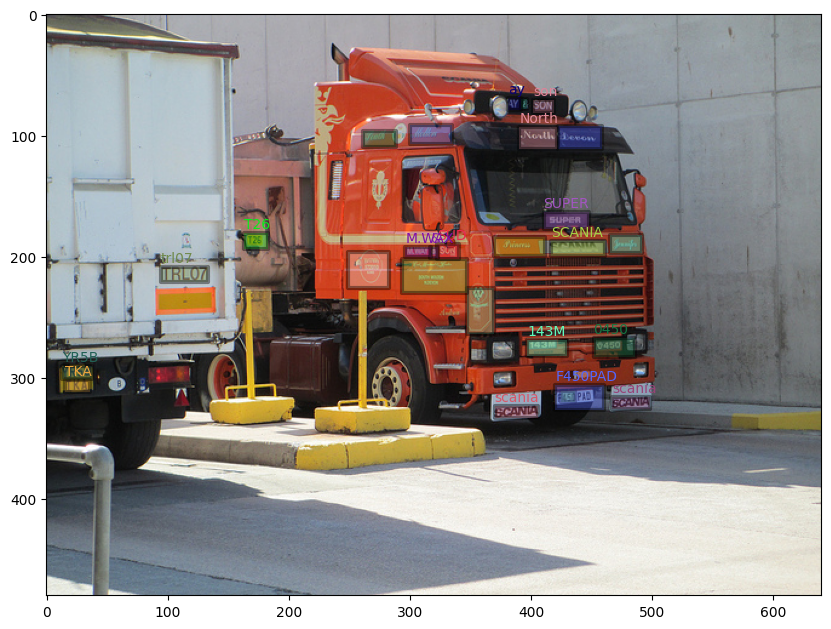

In [2]:
dataDir = "/home/andrzej/PycharmProjects/OCR/data"
dataType = 'train2014'

imgIds = ct.getImgIds(imgIds=ct.train,
                      # catIds=[('legibility','legible')
                      catIds=[('legibility', 'legible'), ('class', 'handwritten')
                              ]
                      )
img = ct.loadImgs(imgIds[np.random.randint(0, len(imgIds))])[0]
# img = ct.loadImgs(162700)[0] # handwritten

img = ct.loadImgs(30585)[0]
print(img)

img_path = '%s/%s/%s' % (dataDir, dataType, img['file_name'])
I = io.imread(img_path)
plt.imshow(I)
annIds = ct.getAnnIds(imgIds=img['id'])
anns = ct.loadAnns(annIds)
print(anns)
ct.showAnns(anns)

# Test EAST and CRAFT

In [3]:
from PIL import Image


def get_image_text_from_image(image, bbox):
    return image[bbox[1]:bbox[1] + bbox[3], bbox[0]:bbox[0] + bbox[2], :]


def plot_image_text(image, bbox):
    image_text = get_image_text_from_image(image, bbox)

    plt.imshow(image_text)
    plt.show()
    return image_text


def plot_image(image):
    plt.imshow(image)
    plt.show()


Image processing

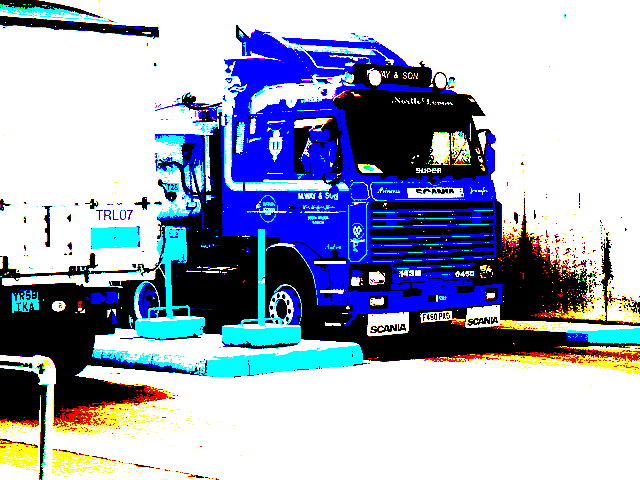

In [4]:
from utils.filters import image_processing_clean_up
import cv2

image_org = cv2.imread(img_path)
image = image_org.copy()
image = image_processing_clean_up(image)
Image.fromarray(np.uint8(image))

Craft

/home/andrzej/PycharmProjects/OCR/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:252: UserWarning: Accessing the model URLs via the internal dictionary of the module is deprecated since 0.13 and may be removed in the future. Please access them via the appropriate Weights Enum instead.
  warnings.warn(
/home/andrzej/PycharmProjects/OCR/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/andrzej/PycharmProjects/OCR/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loading weights from checkpoint (saved_models/craft_mlt_25k.pth)
elapsed time : 2.527698516845703s
number of find text 0.2962962962962963


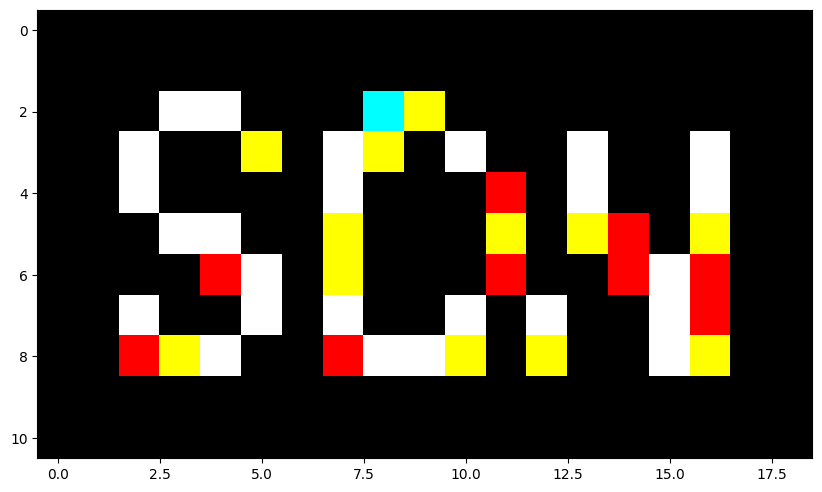

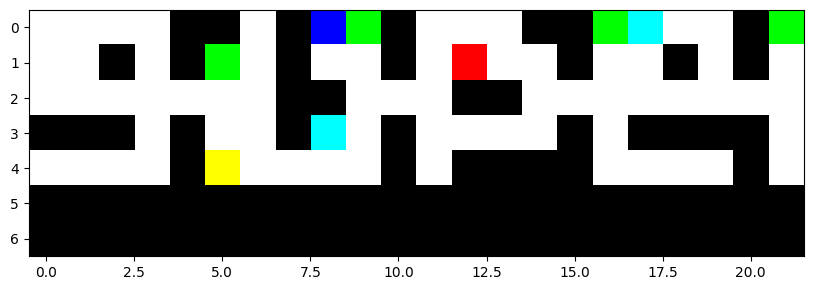

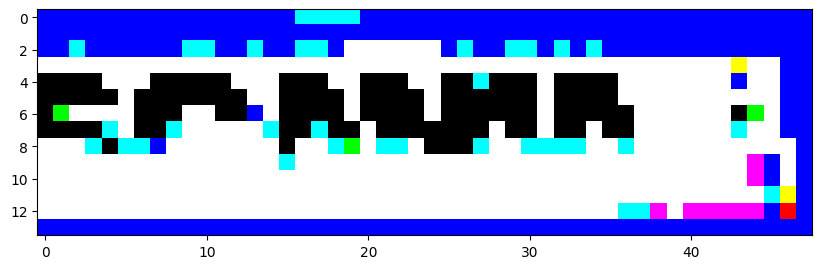

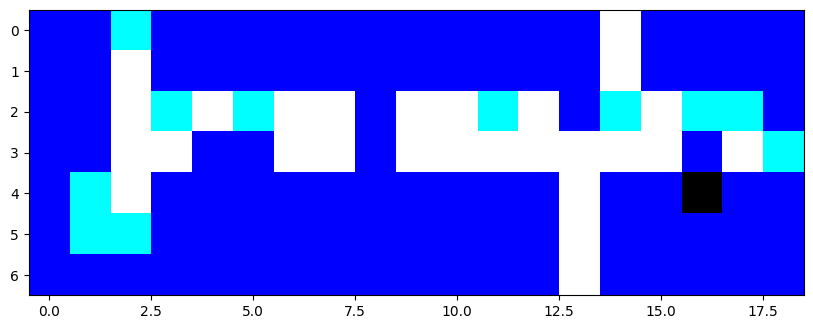

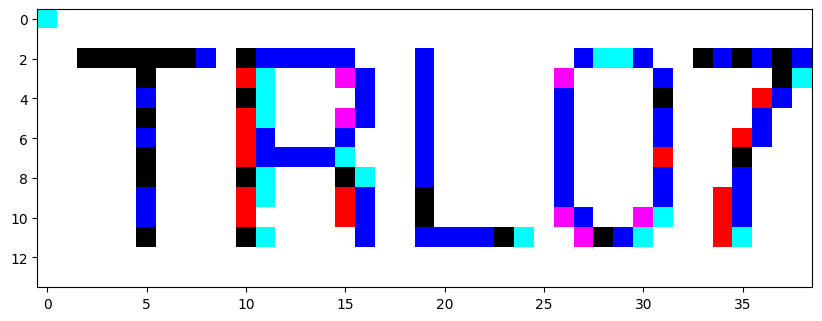

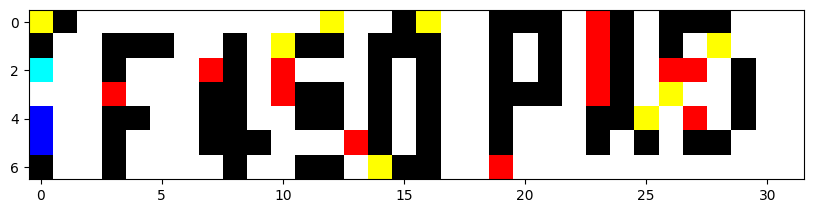

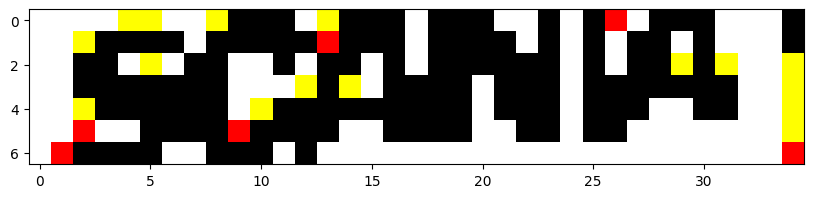

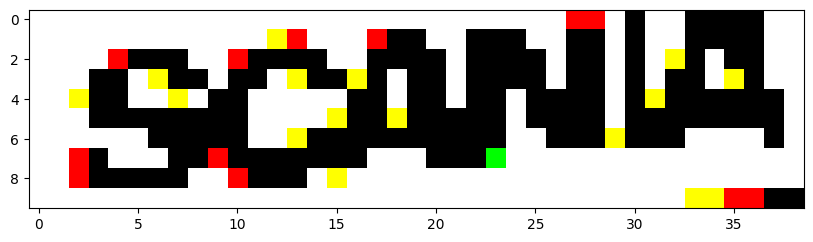

In [5]:
from utils.detect.craft_main import craft_main

# image = image_org.copy()
bboxes = craft_main(image.copy())

print('number of find text',len(bboxes) /len(anns))
images_text = [plot_image_text(image, bbox) for bbox in bboxes]


In [11]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
# microsoft/trocr-base-printed
# microsoft/trocr-base-handwritten

pretrain_model = "microsoft/trocr-base-printed"
processor = TrOCRProcessor.from_pretrained(pretrain_model)
model = VisionEncoderDecoderModel.from_pretrained(pretrain_model)


def read_text_from_image_text(image_text, processor, model):
    pixel_values = processor(image_text, return_tensors="pt").pixel_values
    #
    generated_ids = model.generate(pixel_values)
    #
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_text


def read_all_text_from_images_text(images_text, processor=None, model=None):
    pretrain_model = "microsoft/trocr-base-printed"
    if processor is None: processor = TrOCRProcessor.from_pretrained(pretrain_model)
    if model is None: model = VisionEncoderDecoderModel.from_pretrained(pretrain_model)

    return [read_text_from_image_text(image_text, processor, model) for image_text in images_text]


generated_text = read_all_text_from_images_text(images_text)
generated_text

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The attention ma

['SOM', '#999', 'SRKMAN B', 'HHH', 'TRL07', 'F450 PKS', 'SCANA', 'SCANIA']

# Save result

In [12]:
import json


def save_result(generated_text, bboxes, append=False):
    json_outputs = []
    for text, bbox in zip(generated_text, bboxes):
        json_out = {}
        json_out["utf8_string"] = text
        json_out["image_id"] = img["id"]
        json_out["bbox"] = list(bbox.astype(float))
        json_outputs.append(json_out)

    file_mode = 'a' if append else 'w'

    with open('our_results_test.json', file_mode) as f:
        json.dump(json_outputs, f)

    return json_outputs


save_result(generated_text, bboxes)

[{'utf8_string': 'SOM', 'image_id': 30585, 'bbox': [401.0, 70.0, 19.0, 11.0]},
 {'utf8_string': '#999', 'image_id': 30585, 'bbox': [416.0, 168.0, 22.0, 7.0]},
 {'utf8_string': 'SRKMAN B',
  'image_id': 30585,
  'bbox': [417.0, 185.0, 48.0, 14.0]},
 {'utf8_string': 'HHH', 'image_id': 30585, 'bbox': [469.0, 188.0, 19.0, 7.0]},
 {'utf8_string': 'TRL07',
  'image_id': 30585,
  'bbox': [94.0, 208.0, 39.0, 14.0]},
 {'utf8_string': 'F450 PKS',
  'image_id': 30585,
  'bbox': [420.0, 313.0, 32.0, 7.0]},
 {'utf8_string': 'SCANA',
  'image_id': 30585,
  'bbox': [466.0, 318.0, 35.0, 7.0]},
 {'utf8_string': 'SCANIA',
  'image_id': 30585,
  'bbox': [368.0, 324.0, 39.0, 10.0]}]

# 3 Evaluation API and  End-to-end results

In [13]:
from utils.coco_text import coco_evaluation


def evaluation_and_end_to_end_results(output_file='our_results_test.json'):
    our_results = ct.loadRes(output_file)

    our_detections = coco_evaluation.getDetections(ct, our_results, imgIds=list(our_results.imgs.keys()),
                                                   detection_threshold=0.5)
    # our_detections
    print('True positives have a ground truth id and an evaluation id: ', our_detections['true_positives'][0])
    print('False positives only have an evaluation id: ',
          our_detections['false_positives'][0] if len(our_detections['false_positives']) > 1 else [])
    print('True negatives only have a ground truth id: ',
          our_detections['false_negatives'][0] if len(our_detections['false_negatives']) > 1 else [])

    our_endToEnd_results = coco_evaluation.evaluateEndToEnd(ct, our_results, imgIds=list(our_results.imgs.keys()),
                                                            detection_threshold=0.5)
    coco_evaluation.printDetailedResults(ct, our_detections, our_endToEnd_results, 'our approach')


evaluation_and_end_to_end_results()

Loading and preparing results...     
DONE (t=0.01s)
True positives have a ground truth id and an evaluation id:  {'gt_id': 1008628, 'eval_id': 4}
False positives only have an evaluation id:  {'eval_id': 1}
True negatives only have a ground truth id:  {'gt_id': 1056394}
our approach

Detection
Recall
legible & machine printed:  31.25
legible & handwritten:  0.00
legible overall:  29.41
illegible & machine printed:  0.00
illegible & handwritten:  0
illegible overall:  0.00
total recall:  18.5
Precision
total precision:  62.50
f-score
f-score localization:  28.57

Transcription
accuracy for exact matches:  40.00
accuracy for matches with edit distance<=1:  80.00

End-to-end
recall:  11.76 precision:  25.00
End-to-end f-score:  16.00

31.25 & 0.00 & 0.00 & 0 & 18.5 & 62.50 & 28.57 & 40.00 & 11.76 & 25.00 & 16.00


# Without_filter

/home/andrzej/PycharmProjects/OCR/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:252: UserWarning: Accessing the model URLs via the internal dictionary of the module is deprecated since 0.13 and may be removed in the future. Please access them via the appropriate Weights Enum instead.
  warnings.warn(
/home/andrzej/PycharmProjects/OCR/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/andrzej/PycharmProjects/OCR/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loading weights from checkpoint (saved_models/craft_mlt_25k.pth)
elapsed time : 2.4051053524017334s
0.4074074074074074


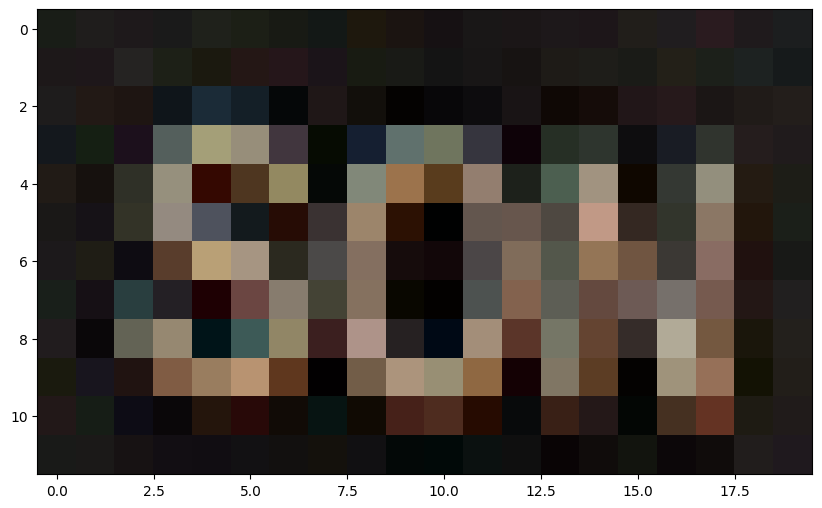

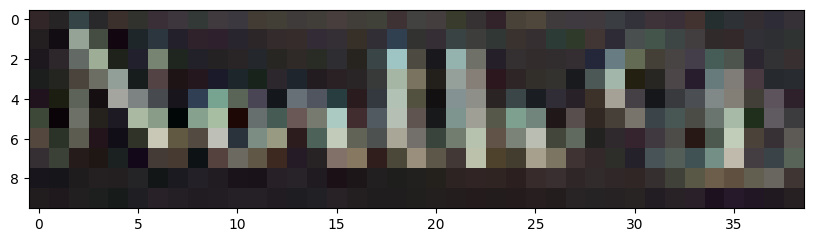

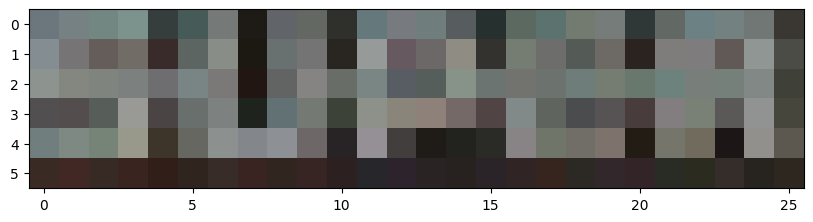

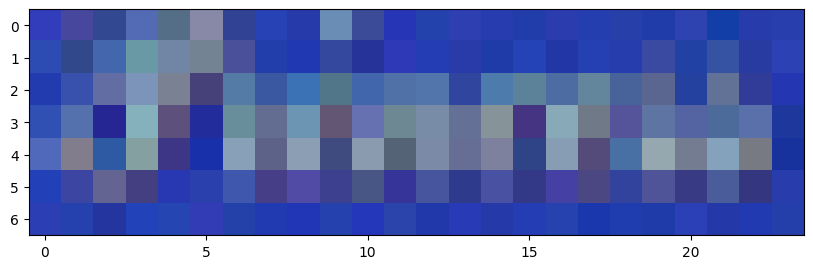

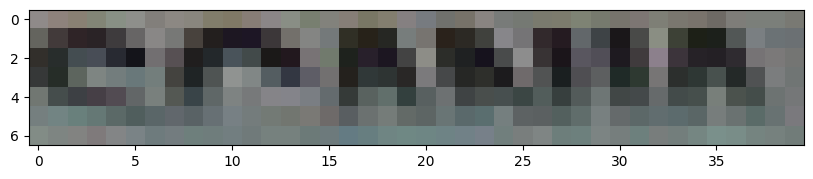

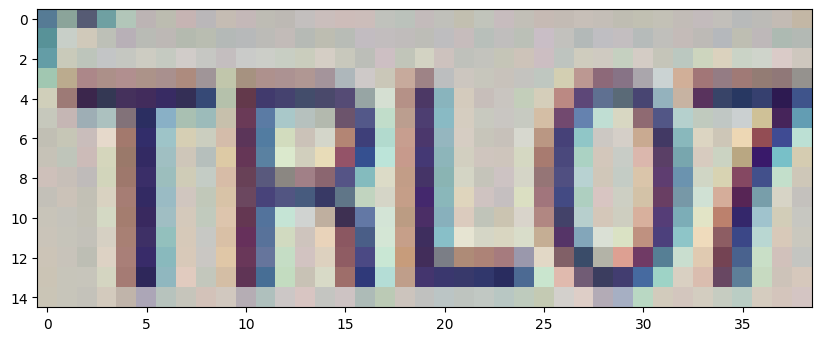

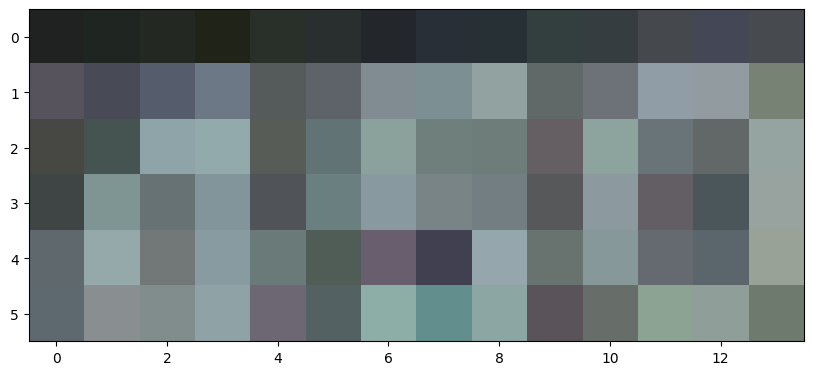

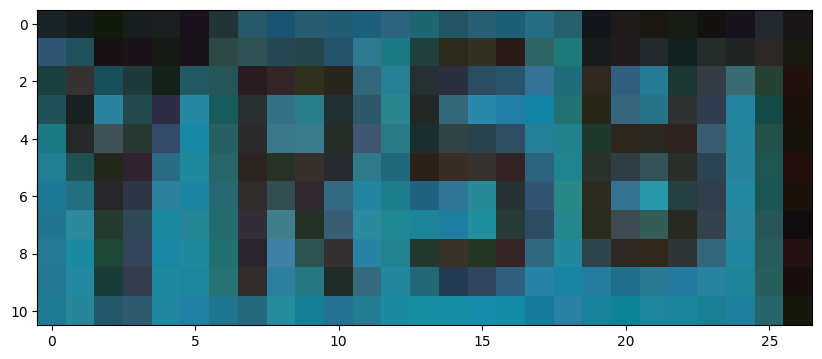

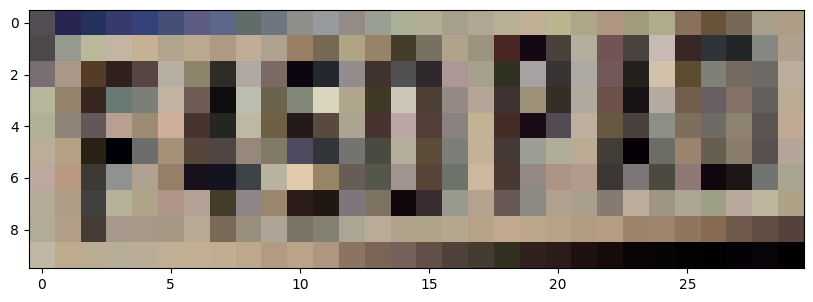

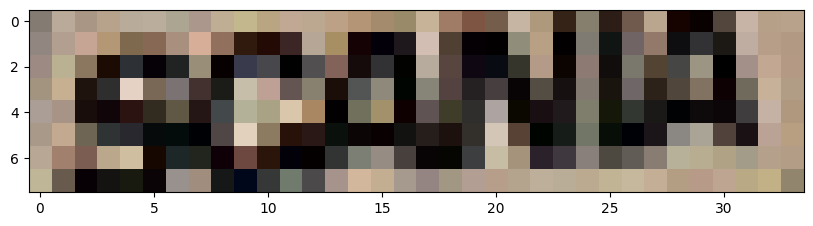

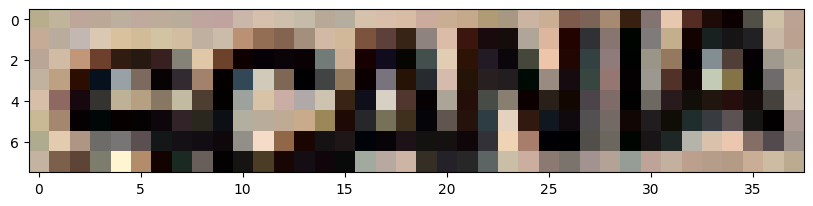

In [36]:
from utils.detect.craft_main import craft_main

image = image_org.copy()
bboxes = craft_main(image.copy())

print('number of find text',len(bboxes) /len(anns))
images_text = [plot_image_text(image, bbox) for bbox in bboxes]

In [15]:
generated_text = read_all_text_from_images_text(images_text)
save_result(generated_text,bboxes)
evaluation_and_end_to_end_results()

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
/home/andrzej/PycharmProjects/OCR/venv/lib/python3.9/site-packages/transformers/generation/utils.py:1387: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`self.config.max_length`). Controlling `max_length` v

Loading and preparing results...     
DONE (t=0.01s)
True positives have a ground truth id and an evaluation id:  {'gt_id': 1008628, 'eval_id': 5}
False positives only have an evaluation id:  {'eval_id': 1}
True negatives only have a ground truth id:  {'gt_id': 1056394}
our approach

Detection
Recall
legible & machine printed:  31.25
legible & handwritten:  0.00
legible overall:  29.41
illegible & machine printed:  0.00
illegible & handwritten:  0
illegible overall:  0.00
total recall:  18.5
Precision
total precision:  45.45
f-score
f-score localization:  26.32

Transcription
accuracy for exact matches:  60.00
accuracy for matches with edit distance<=1:  100.00

End-to-end
recall:  17.65 precision:  27.27
End-to-end f-score:  21.43

31.25 & 0.00 & 0.00 & 0 & 18.5 & 45.45 & 26.32 & 60.00 & 17.65 & 27.27 & 21.43


Filter only images_text

Loading weights from checkpoint (saved_models/craft_mlt_25k.pth)
elapsed time : 2.5975494384765625s
number of find text 0.4074074074074074


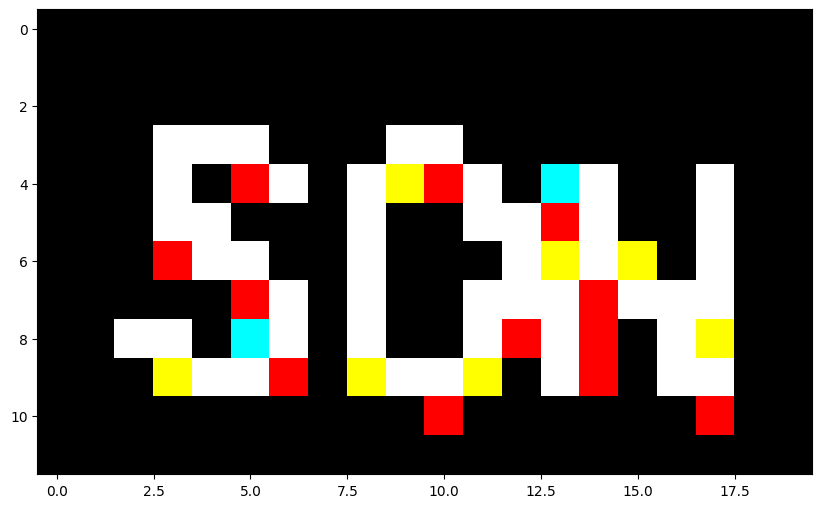

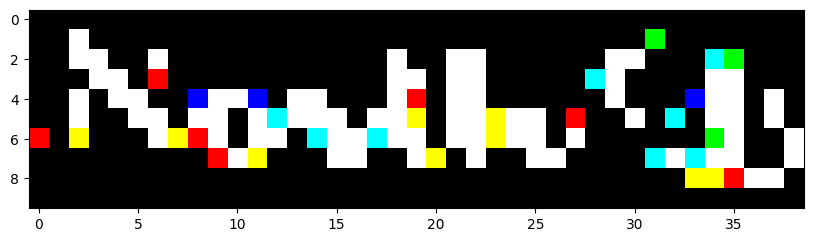

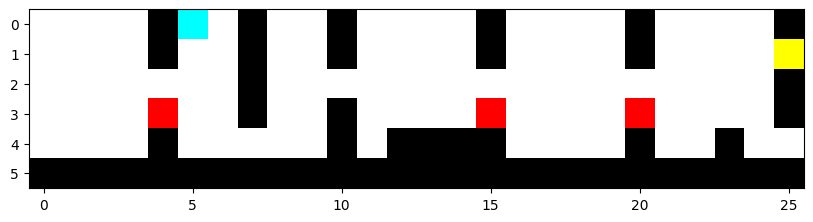

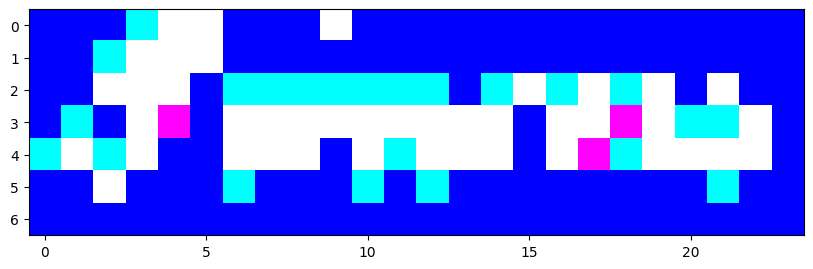

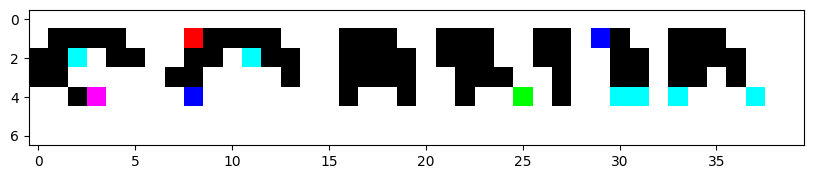

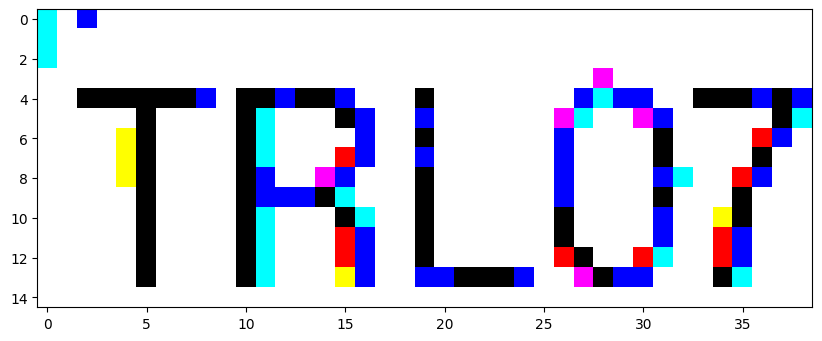

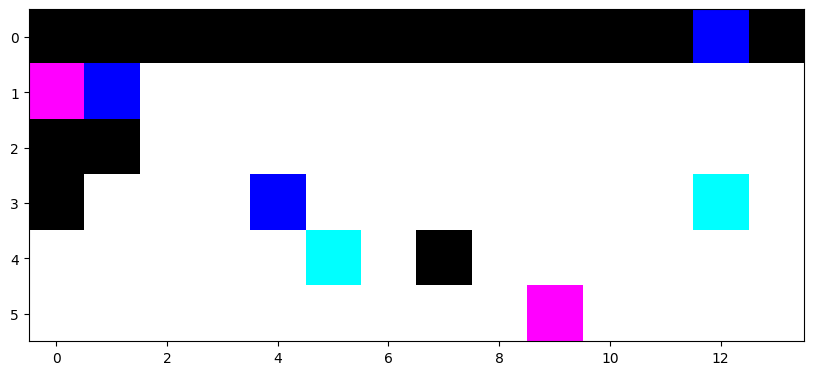

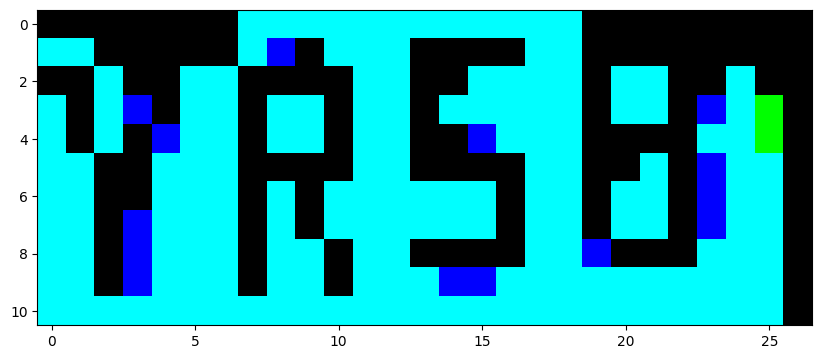

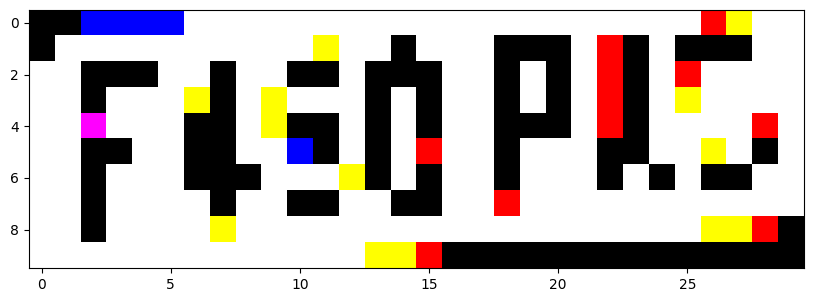

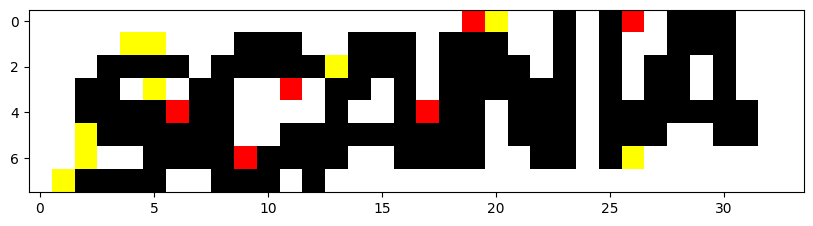

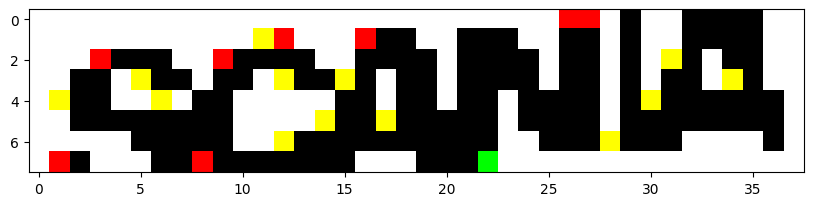

In [6]:
from utils.detect.craft_main import craft_main

image = image_org.copy()
bboxes = craft_main(image.copy())

# print(len(bboxes))
print('number of find text',len(bboxes) /len(anns))
images_text = [ image_processing_clean_up(get_image_text_from_image(image, bbox)) for bbox in bboxes]

for image in images_text:
    plot_image(image)

In [21]:
generated_text = read_all_text_from_images_text(images_text)
save_result(generated_text,bboxes)
evaluation_and_end_to_end_results()

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
/home/andrzej/PycharmProjects/OCR/venv/lib/python3.9/site-packages/transformers/generation/utils.py:1387: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`self.config.max_length`). Controlling `max_length` v

Loading and preparing results...     
DONE (t=0.01s)
True positives have a ground truth id and an evaluation id:  {'gt_id': 1008628, 'eval_id': 5}
False positives only have an evaluation id:  {'eval_id': 1}
True negatives only have a ground truth id:  {'gt_id': 1056394}
our approach

Detection
Recall
legible & machine printed:  31.25
legible & handwritten:  0.00
legible overall:  29.41
illegible & machine printed:  0.00
illegible & handwritten:  0
illegible overall:  0.00
total recall:  18.5
Precision
total precision:  45.45
f-score
f-score localization:  26.32

Transcription
accuracy for exact matches:  60.00
accuracy for matches with edit distance<=1:  100.00

End-to-end
recall:  17.65 precision:  27.27
End-to-end f-score:  21.43

31.25 & 0.00 & 0.00 & 0 & 18.5 & 45.45 & 26.32 & 60.00 & 17.65 & 27.27 & 21.43
